In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [3]:
df = pd.read_csv('Fraud.csv')  # Input data files are available in the read-only "../input/" directory.
df.head()                      #list top 5 rows in the data det.

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
#Check if the recipient is a merchant or not

aux = []
for Dest in df['nameDest'].values:
    if Dest[0] == 'M':
        merchant = 1
    else:
        merchant = 0
    aux.append(merchant)

#Create boolean column for merchant
df['Destmerchant'] = aux

In [6]:
#Turn off information oldbalanceDest and newbalanceDest of merchants and preencher with NaN
df['oldbalanceDest'] = df['oldbalanceDest'].where(df['Destmerchant'] == 0, other=np.nan)
df['newbalanceDest'] = df['newbalanceDest'].where(df['Destmerchant'] == 0, other=np.nan)

Due to the size of the dataset, it was not computationally possible to identify the missing values. But after we corrected the oldbalanceDest and newbalanceDest columns, we became aware of their existence. For now we will not worry about this information and we will keep it that way

In [7]:
display(df.describe().transpose())  

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.00,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.94,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.00,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.00,1.442584e+05,4.958504e+07
oldbalanceDest,4211125.0,1.663058e+06,4.064780e+06,0.0,139659.05,551247.21,1.692951e+06,3.560159e+08
newbalanceDest,4211125.0,1.850856e+06,4.386080e+06,0.0,221717.59,683724.79,1.910979e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.00,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.00,0.000000e+00,1.000000e+00
Destmerchant,6362620.0,3.381461e-01,4.730786e-01,0.0,0.00,0.00,1.000000e+00,1.000000e+00


In [8]:
#Create checklist if nameOrig is equal to nameDest
mylist = list(df['nameOrig'] == df['nameDest'])

#Check unique values of list created
myset = set(mylist)
print(f'List of unique values gives list created: {myset}')

List of unique values gives list created: {False}


All transactions are between different senders and recipients. Thus, this information does not become relevant to the solution of our problem. But before your exclusions, we will now verify if there is any merchant among the clients who will send the transactions. This information may be useful in the future and we will keep this observation for the intended customers

In [9]:
aux = []
for Dest in df['nameOrig'].values:
    if Dest[0] == 'M':
        merchant = 1
    else:
        merchant = 0
    aux.append(merchant)

myset = set(aux)
print(f'List of unique values gives aux list created: {myset}')

List of unique values gives aux list created: {0}


Since there are no merchants among the senders, we can now exclude the columns nameOrig and nameDest

In [10]:
df = df.drop(['nameOrig','nameDest'], axis=1)


We know that the column step maps the time, but we don't know the starting point of this mapping. So, we can't trace more information for our problem. For example, we don't know if the transaction occurred during the day or during the night, or left during the week or during the weekend. For this reason we will also exclude this information


In [11]:
df = df.drop('step', axis=1)


We have our dataset corrected in the following way now:

In [12]:
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Destmerchant
0,PAYMENT,9839.64,170136.0,160296.36,NaN,NaN,0,0,1
1,PAYMENT,1864.28,21249.0,19384.72,NaN,NaN,0,0,1
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,0
4,PAYMENT,11668.14,41554.0,29885.86,NaN,NaN,0,0,1


In [13]:
df.shape     # showing the number of rows and colums

(6362620, 9)

In [14]:
df.isna().sum()  # Checking for null values

type                    0
amount                  0
oldbalanceOrg           0
newbalanceOrig          0
oldbalanceDest    2151495
newbalanceDest    2151495
isFraud                 0
isFlaggedFraud          0
Destmerchant            0
dtype: int64

In [15]:
df['isFraud'].value_counts()  


0    6354407
1       8213
Name: isFraud, dtype: int64

([<matplotlib.patches.Wedge at 0x1fe44b08d90>,
 [Text(-1.099990955625572, 0.004460666087110192, ''),
  Text(1.0999909559371663, -0.004460589247970448, '')],
 [Text(-0.5999950667048575, 0.002433090592969195, '99.871%'),
  Text(0.599995066874818, -0.002433048680711153, '0.129%')])

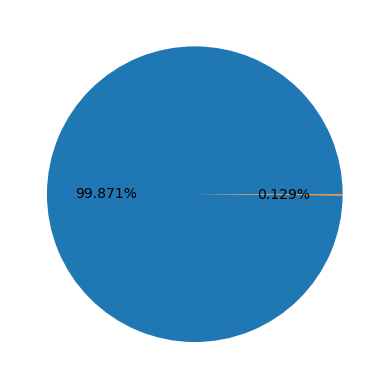

In [16]:
plt.pie(df['isFraud'].value_counts(),  autopct='%.3f%%')  # To see actual values

Dataset is highly imbalanced. Only 0.129 % are fraud .


In [17]:
standard_Transactions = len(df[df['isFraud'] == 0])
fraudulent_Transactions = len(df[df['isFraud'] == 1])
print('\nQuantity of Standard Transactions: {:,} ({:1.4%})'.format(standard_Transactions, standard_Transactions/len(df)))
print('Quantity of Fraudulent Transactions: {:,} ({:1.4%})\n'.format(fraudulent_Transactions, fraudulent_Transactions/len(df)))


Quantity of Standard Transactions: 6,354,407 (99.8709%)
Quantity of Fraudulent Transactions: 8,213 (0.1291%)



There is a very large imbalance given to us for our classification. We have a lot of information for normal versus fraudulent transactions. also able to send our results to the proposed Random Forest model.

In [18]:
#Separate our classes

df_tr_fraud = df[df['isFraud'] == 1]
df_tr_norm = df[df['isFraud'] == 0]

print(df_tr_fraud)
print(df_tr_norm)

             type      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2        TRANSFER      181.00         181.00             0.0            0.00   
3        CASH_OUT      181.00         181.00             0.0        21182.00   
251      TRANSFER     2806.00        2806.00             0.0            0.00   
252      CASH_OUT     2806.00        2806.00             0.0        26202.00   
680      TRANSFER    20128.00       20128.00             0.0            0.00   
...           ...         ...            ...             ...             ...   
6362615  CASH_OUT   339682.13      339682.13             0.0            0.00   
6362616  TRANSFER  6311409.28     6311409.28             0.0            0.00   
6362617  CASH_OUT  6311409.28     6311409.28             0.0        68488.84   
6362618  TRANSFER   850002.52      850002.52             0.0            0.00   
6362619  CASH_OUT   850002.52      850002.52             0.0      6510099.11   

         newbalanceDest  isFraud  isFla

In [19]:
#Balance as classes by undersampling



#Decrease our major class to the size of our minor class
df_tr_norm_under = df_tr_norm.sample(fraudulent_Transactions, random_state=1)

print(df_tr_norm_under)

             type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
1697235   CASH_IN  290448.64       49671.00       340119.64        34047.63   
491213    PAYMENT    7521.26           0.00            0.00             NaN   
2663119   PAYMENT   12043.69           0.00            0.00             NaN   
5159889   CASH_IN  120116.21       97688.68       217804.90       849069.38   
2707009  CASH_OUT  115161.12           0.00            0.00       576802.51   
...           ...        ...            ...             ...             ...   
781854    CASH_IN  350258.30         631.00       350889.30       804931.80   
6128552  CASH_OUT    2513.85       21608.00        19094.15      9414586.35   
4339471  CASH_OUT    4390.62       41913.00        37522.38       362457.97   
610069    PAYMENT    3855.74      796208.46       792352.73             NaN   
482244    PAYMENT   15979.75           0.00            0.00             NaN   

         newbalanceDest  isFraud  isFlaggedFraud  D

In [20]:


#Join our classes again
df_balanced = pd.concat([df_tr_fraud, df_tr_norm_under])
df_balanced = df_balanced.reset_index(drop=True)

print(df_balanced)

           type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0      TRANSFER     181.00         181.00            0.00            0.00   
1      CASH_OUT     181.00         181.00            0.00        21182.00   
2      TRANSFER    2806.00        2806.00            0.00            0.00   
3      CASH_OUT    2806.00        2806.00            0.00        26202.00   
4      TRANSFER   20128.00       20128.00            0.00            0.00   
...         ...        ...            ...             ...             ...   
16421   CASH_IN  350258.30         631.00       350889.30       804931.80   
16422  CASH_OUT    2513.85       21608.00        19094.15      9414586.35   
16423  CASH_OUT    4390.62       41913.00        37522.38       362457.97   
16424   PAYMENT    3855.74      796208.46       792352.73             NaN   
16425   PAYMENT   15979.75           0.00            0.00             NaN   

       newbalanceDest  isFraud  isFlaggedFraud  Destmerchant  
0           

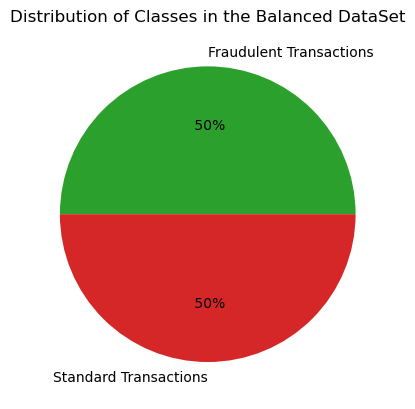

In [21]:
plt.pie(
        [len(df_balanced[df_balanced['isFraud'] == 1]), len(df_balanced[df_balanced['isFraud'] == 0])],
        labels=['Fraudulent Transactions', 'Standard Transactions'],
        autopct='%3.0f%%',
        colors=['tab:green', 'tab:red']
       )
plt.title('Distribution of Classes in the Balanced DataSet')
plt.show()

In [22]:
df.nunique()


type                    5
amount            5316900
oldbalanceOrg     1845844
newbalanceOrig    2682586
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
Destmerchant            2
dtype: int64

In [23]:
pd.set_option('display.float_format', '{:.2f}'.format)         # To see actual values
df.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Destmerchant
count,6362620.00,6362620.00,6362620.00,4211125.00,4211125.00,6362620.00,6362620.00,6362620.00
mean,179861.90,833883.10,855113.67,1663058.31,1850856.14,0.00,0.00,0.34
std,603858.23,2888242.67,2924048.50,4064779.99,4386080.47,0.04,0.00,0.47
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,13389.57,0.00,0.00,139659.05,221717.59,0.00,0.00,0.00
50%,74871.94,14208.00,0.00,551247.21,683724.79,0.00,0.00,0.00
75%,208721.48,107315.18,144258.41,1692950.88,1910978.53,0.00,0.00,1.00
max,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00,1.00


C:\Users\vasanthkumaran\AppData\Local\Temp\ipykernel_14980\1972026960.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_balanced.corr(),cmap="YlGnBu",annot=True)


<Axes: >

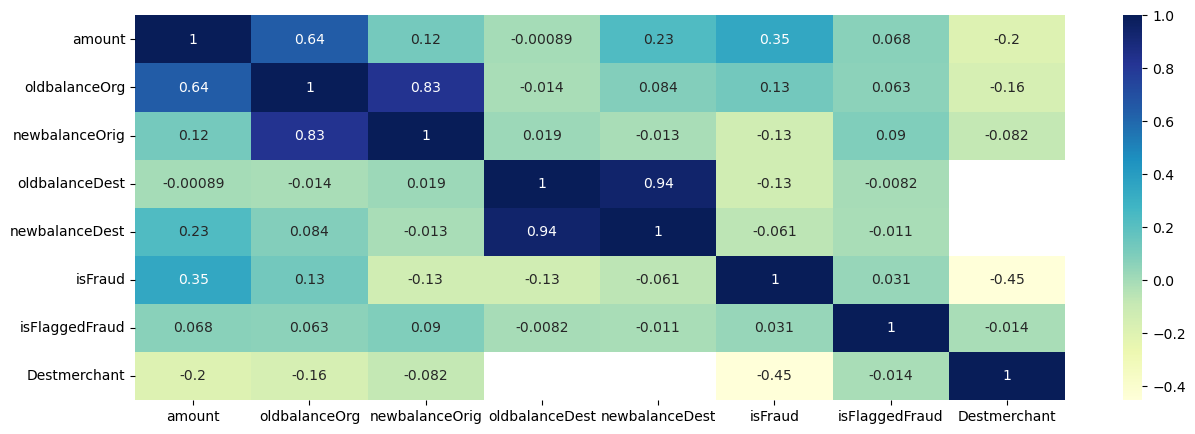

In [24]:
#check for correlation
plt.figure(figsize=(15,5))
sns.heatmap(df_balanced.corr(),cmap="YlGnBu",annot=True)

In [25]:
df_balanced = df_balanced.fillna(0)

# Train test split-

In [26]:
x = df_balanced.drop('isFraud', axis=1)
y = df_balanced['isFraud']

In [27]:
x = pd.get_dummies(x)
display(x.head())

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,Destmerchant,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,181.00,181.00,0.00,0.00,0.00,0,0,0,0,0,0,1
1,181.00,181.00,0.00,21182.00,0.00,0,0,0,1,0,0,0
2,2806.00,2806.00,0.00,0.00,0.00,0,0,0,0,0,0,1
3,2806.00,2806.00,0.00,26202.00,0.00,0,0,0,1,0,0,0
4,20128.00,20128.00,0.00,0.00,0.00,0,0,0,0,0,0,1


In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30,random_state=0)


# Model training - Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.tree import plot_tree

classify_fraud = RandomForestClassifier(n_estimators=100, random_state=1)

#train model
classify_fraud.fit(x_train, y_train)

#test model
y_pred = classify_fraud.predict(x_test)

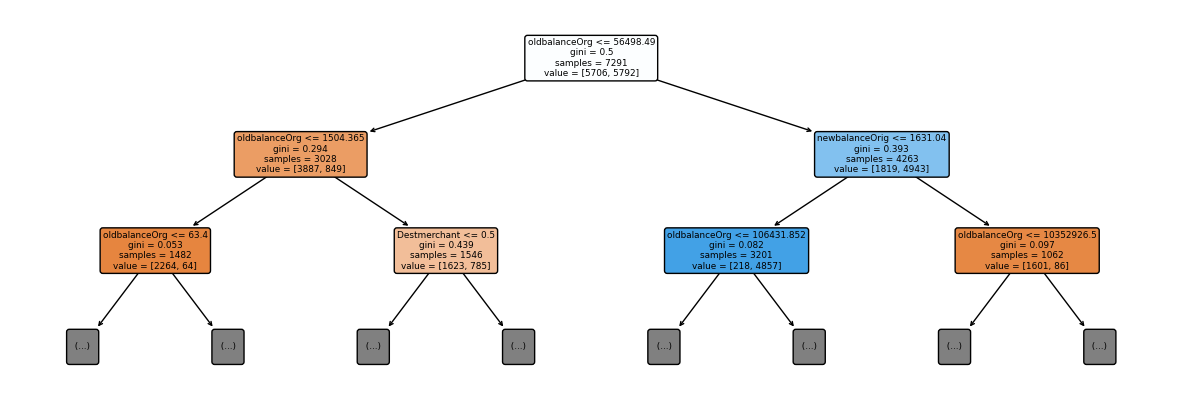

In [30]:
n_tree=50
fig = plt.figure(figsize=(15, 5))
plot_tree(
          classify_fraud.estimators_[n_tree],
          feature_names=x.columns,
          max_depth=2,
          filled=True, impurity=True, rounded=True
         )
plt.show()

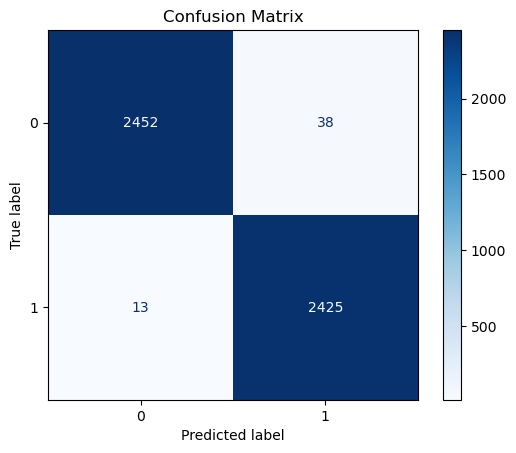



Classification Report:

               precision    recall  f1-score   support

           0       0.99      0.98      0.99      2490
           1       0.98      0.99      0.99      2438

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928



In [31]:
#Tree Model

graphic = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=classify_fraud.classes_)
graphic.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print('\n\nClassification Report:\n\n',classification_report(y_test, y_pred))

In [32]:
#roll dice
feature_importances = pd.DataFrame(classify_fraud.feature_importances_, x.columns)
feature_importances = feature_importances.sort_values(by=0, ascending=False)
feature_importances = feature_importances.rename(columns={0: 'Importance of Characteristic'})


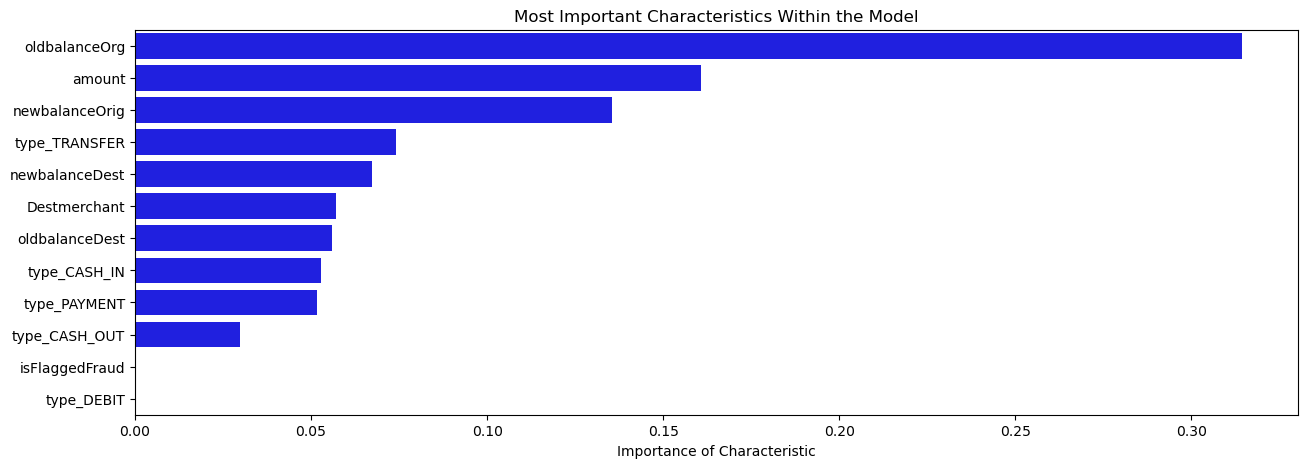

In [33]:
#plot graphic

plt.figure(figsize=(15,5))
sns.barplot(x=feature_importances['Importance of Characteristic'], y=feature_importances.index, color='blue')
plt.title('Most Important Characteristics Within the Model')
plt.show()

Graphically of the most important characteristics within the model we see some important points:

The marking of 'isFlaggedfraud', which could be an important indicator for fraud attempts, matters little within the model. For the established business rules according to the dictionary, only 16 times have they been flagged for a fraud that de facto occurred in front of others 8197 times that it occurred and were not flagged

Note-I also know that the type of movement being in the form of debit seems to be the safest as far as transference needs more attention